# Training script ( to use pre-trained script run predict script below )

In [218]:
import pandas as pd
import keras
from numpy import array, pad
from numpy import argmax
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, GRU, Conv1D
from keras.layers import Dense, Flatten, RepeatVector, TimeDistributed, Dropout, Embedding, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

# function to encode a sequence into codons
def get_codons(sequence):
    codons = []
    for i in range(0, len(sequence), 3):
        if i+3 <= len(sequence):
            codon = sequence[i:i+3]
            #codon = codon_dict[codon]
            codons.append(codon)
    return codons


df = pd.read_csv('../resources/csv/k_12ref.csv')
# dictionary to map codons to integers
codon_dict = {'AAA': 0,'AAC': 1, 'AAG': 2, 'AAT': 3, 'ACA': 4, 'ACC': 5, 'ACG': 6, 'ACT': 7, 
              'AGA': 8, 'AGC': 9, 'AGG': 10, 'AGT': 11, 'ATA': 12, 'ATC': 13, 'ATG': 14, 'ATT': 15, 
              'CAA': 16, 'CAC': 17, 'CAG': 18, 'CAT': 19, 'CCA': 20, 'CCC': 21, 'CCG': 22, 'CCT': 23, 
              'CGA': 24, 'CGC': 25, 'CGG': 26, 'CGT': 27, 'CTA': 28, 'CTC': 29, 'CTG': 30, 'CTT': 31, 
              'GAA': 32, 'GAC': 33, 'GAG': 34, 'GAT': 35, 'GCA': 36, 'GCC': 37, 'GCG': 38, 'GCT': 39, 
              'GGA': 40, 'GGC': 41, 'GGG': 42, 'GGT': 43, 'GTA': 44, 'GTC': 45, 'GTG': 46, 'GTT': 47, 
              'TAA': 48, 'TAC': 49, 'TAG': 50, 'TAT': 51, 'TCA': 52, 'TCC': 53, 'TCG': 54, 'TCT': 55, 
              'TGA': 56, 'TGC': 57, 'TGG': 58, 'TGT': 59, 'TTA': 60, 'TTC': 61, 'TTG': 62, 'TTT': 63}

# dictionary to map protein to integers
amino_acid_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,"*": 0}
max_seq = len(df["DNA"])
max_pro = df["Protein"].str.len().max()
d_nuc = list()
d_pro = list()

for seq in df["DNA"]:
    codons = get_codons(seq)
    nucleotide_tokens = [codon_dict[x] for x in codons]
    d_nuc.append(nucleotide_tokens)
d_nuc = pad_sequences(d_nuc, padding="post")
for seq in df["Protein"]:
    aminoacid_tokens = [amino_acid_dict[x] for x in seq]
    d_pro.append(aminoacid_tokens)

d_pro = pad_sequences(d_pro, padding="post")
d_nuc = array(d_nuc)
print(d_nuc.shape)
d_pro = array(d_pro)
print(d_nuc.shape)
d_pro = d_pro.reshape(max_seq,max_pro,1)
d_nuc = d_nuc.reshape(max_seq,max_pro,1)

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model = Sequential()
model.add(Embedding(21, 128, input_length=max_pro, input_shape=(max_pro, ),mask_zero=True))
model.add(Conv1D(128, 1, activation="relu", input_shape=(max_pro,), padding='valid'))
model.add(Dropout(0.3))
model.add(Conv1D(128, 1, activation="relu", input_shape=(max_pro,), padding='valid'))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(64, activation='relu', return_sequences=True)))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(65, activation='softmax')))
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print(model.summary())
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True), ModelCheckpoint('../resources/models/CRopt.h5')]
model.fit(d_pro, d_nuc, epochs=2, batch_size = 64, validation_split=0.2, callbacks = callbacks)

(4315, 2359)
(4315, 2359)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 2359, 128)         2688      
                                                                 
 conv1d_34 (Conv1D)          (None, 2359, 128)         16512     
                                                                 
 dropout_51 (Dropout)        (None, 2359, 128)         0         
                                                                 
 conv1d_35 (Conv1D)          (None, 2359, 128)         16512     
                                                                 
 dropout_52 (Dropout)        (None, 2359, 128)         0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 2359, 128)        74496     
 onal)                                                           
                           

# Predict script 

In [219]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import codon2aa
import numpy as np
import random
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
# give the file name of the fasta sequence of protein that needs to optimised 
# dictionary to map codons to integers
codon_dict = {'AAA': 0,'AAC': 1, 'AAG': 2, 'AAT': 3, 'ACA': 4, 'ACC': 5, 'ACG': 6, 'ACT': 7, 
              'AGA': 8, 'AGC': 9, 'AGG': 10, 'AGT': 11, 'ATA': 12, 'ATC': 13, 'ATG': 14, 'ATT': 15, 
              'CAA': 16, 'CAC': 17, 'CAG': 18, 'CAT': 19, 'CCA': 20, 'CCC': 21, 'CCG': 22, 'CCT': 23, 
              'CGA': 24, 'CGC': 25, 'CGG': 26, 'CGT': 27, 'CTA': 28, 'CTC': 29, 'CTG': 30, 'CTT': 31, 
              'GAA': 32, 'GAC': 33, 'GAG': 34, 'GAT': 35, 'GCA': 36, 'GCC': 37, 'GCG': 38, 'GCT': 39, 
              'GGA': 40, 'GGC': 41, 'GGG': 42, 'GGT': 43, 'GTA': 44, 'GTC': 45, 'GTG': 46, 'GTT': 47, 
              'TAA': 48, 'TAC': 49, 'TAG': 50, 'TAT': 51, 'TCA': 52, 'TCC': 53, 'TCG': 54, 'TCT': 55, 
              'TGA': 56, 'TGC': 57, 'TGG': 58, 'TGT': 59, 'TTA': 60, 'TTC': 61, 'TTG': 62, 'TTT': 63}

# dictionary to map protein to integers
amino_acid_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 
                   'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,"*": 0}

model = load_model("../resources/models/CRopt.h5")
topt= "../resources/fasta/original.fasta"
opt = "../results/fasta/CRopt.fasta"
os.remove(opt)

max_pro = 2359
with open(topt) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        gene_name = record.id
        test_data = record.seq
        test_data = test_data.replace("\n", "")
        if test_data[-1] != "*":
            test_data += "*"
        t_pro =[]
        aminoacid_tokens = [amino_acid_dict[x] for x in test_data]
        t_pro.append(aminoacid_tokens)
        t_pro = np.array(t_pro)
        t_pro = pad_sequences(t_pro, padding="post", maxlen = max_pro)
        t_pro = t_pro.reshape((1, max_pro, 1))
        predicted = model.predict(t_pro, verbose=1)
        predicted_seq = ""
        i = 1
        for prob in predicted[0]:
            if i < len(test_data):
                codons = list(codon_dict.keys())
                predicted_aa = codons[np.argmax(prob)]
                predicted_seq += predicted_aa
                i+=1
        predicted_seq+= random.choice(["TGA","TAA","TAG"])
        print(predicted_seq)
        
        with open(opt, "a") as output:
            record = SeqRecord(Seq(predicted_seq), id=gene_name, description= str())
            SeqIO.write(record, output, "fasta") 

1/1 [==============================] - 1s 902ms/step
ATGAGCGATGTGGCGATTGTGAAAGAAGGCTGGCTGCACAAACGCGGCGAATATATTAAAACCTGGCGCCCGCGCTATTTTCTGCTGAAAAATGATGGCACCTTTATTGGCTATAAAGAACGCCCGCAGGATGTTGATCAGCGTGAAGCGCCGCTGAATAATTTTAGCGTGGCGCAGTGCCAGCTGATGAAAACCGAACGCCCGCGCCCGAACACCTTTATTATTCGCTGCCTGCAGTGGACCACCGTGATTGAACGCACCTTTCATGTTGAAACGCCGGAAGAACGTGAAGAATGGACCACCGCGATTCAGACCGTTGCGGATGGCCTGAAAAAACAGGAAGAAGAAGAGATGGATTTTCGCAGCGGCAGCCCGAGCGATAACAGCGGCGCGGAAGAGATGGAAGTGTCGCTGGCGAAACCGAAACATCGCGTGACCATGAATGAATTTGAATATCTGAAACTGCTGGGCAAAGGCACCTTTGGCAAAGTGATTCTGGTGAAAGAAAAAGCGACCGGCCGCTATTATGCGATGAAAATTCTGAAAAAAGAAGTGATTGTTGCGAAAGATGAAGTTGCGCATACGCTGACCGAAAACCGCGTGCTGCAGAACAGCCGCCATCCGTTTCTGACCGCGCTGAAATATAGCTTTCAGACCCACGATCGTCTGTGCTTTGTGATGGAATATGCCAACGGCGGCGAACTGTTTTTTCATCTGAGCCGTGAACGCGTGTTTAGCGAAGATCGCGCGCGCTTTTATGGCGCGGAAATTGTTAGCGCGCTGGATTATCTGCACAGCGAAAAAAATGTGGTGTATCGCGATCTGAAACTGGAAAACCTGATGCTGGATAAAGATGGCCATATTAAAATTACCGATTTTGGCCTGTGCAAAGAAGGCATTAAAGATGGCGCGACCATGAAAACCTTTTGCGGCACGCCGGAATATCT

1/1 [==============================] - 0s 343ms/step
ATGGGCGGCTGCGCGGGCAGCCGCCGCCGCTTTAGCGATAGCGAAGGCGAAGAAACCGTGCCGGAACCGCGTCTGCCGCTGCTGGATCATCAGGGCGCGCATTGGAAAAATGCGGTGGGCTTTTGGCTGCTGGGCCTGTGCAATAACTTTAGCTATGTGGTGATGCTGAGCGCGGCGCACGATATTCTGAGCCACAAACGCACCAGCGGCAACCAGAGCCACGTGGATCCGGGCCCGACGCCGATTCCGCATAACAGCAGCAGCCGCTTTGATTGCAACAGCGTGAGCACCGCGGCGGTGCTGCTGGCGGATATTCTGCCGACGCTGGTGATTAAACTGCTGGCGCCGCTGGGCCTGCATCTGCTGCCGTATAGCCCGCGCGTGCTGGTGAGCGGCATTTGCGCCGCGGGCAGCTTTGTGCTGGTGGCGTTTAGCCACAGCGTGGGCACCTCGCTGTGCGGCGTGGTGTTTGCGAGCATTAGCAGCGGCCTGGGCGAAGTGACCTTTCTGTCGCTGACCGCGTTTTATCCGCGCGCGGTGATTAGCTGGTGGAGCAGCGGCACCGGCGGCGCGGGCCTGCTGGGCGCGCTGAGCTATCTGGGCCTGACCCAGGCGGGCCTGAGCCCGCAGCAGACGCTGCTGTCGATGCTGGGCATTCCGGCGCTGCTGCTGGCGAGCTATTTTCTGCTGCTGACCAGCCCGGAAGCGCAGGATCCGGGCGGCGAAGAAGAAGCGGAAAGCGCGGCGCGTCAGCCGCTGATTCGCACCGAAGCGCCGGAAAGCAAACCGGGCAGCAGCAGCTCGCTGTCGCTGCGTGAACGCTGGACCGTGTTTAAAGGCCTGCTGTGGTATATTGTGCCGCTGGTGGTGGTGTATTTTGCGGAATATTTTATTAACCAGGGCCTGTTTGAACTGCTGTTTTTTTGGAATACCTCGCTGAGCCACGC

1/1 [==============================] - 0s 352ms/step
ATGAGCGGCCGCCCGCGCACCACCAGCTTTGCGGAAAGCTGCAAACCGGTGCAGCAGCCGAGCGCGTTTGGCAGCATGAAAGTGAGCCGCGATAAAGATGGCAGCAAAGTGACCACCGTGGTTGCGACGCCGGGCCAGGGCCCGGATCGCCCGCAGGAAGTGAGCTATACCGATACCAAAGTGATTGGCAACGGCAGCTTTGGCGTGGTGTATCAGGCGAAACTGTGCGATAGCGGCGAACTGGTGGCGATTAAAAAAGTGCTGCAGGATAAACGCTTTAAAAACCGCGAACTGCAGATTATGCGTAAACTGGATCACTGCAATATTGTGCGTCTGCGCTATTTTTTTTATAGCAGCGGCGAAAAAAAAGATGAAGTGTATCTGAACCTGGTGCTGGATTATGTGCCGGAAACCGTGTATCGCGTTGCGCGCCATTATAGCCGCGCGAAACAGACGCTGCCGGTGATTTATGTGAAACTGTATATGTATCAGCTGTTTCGCTCGCTGGCGTATATTCACAGCTTTGGCATTTGCCATCGCGATATTAAACCGCAGAACCTGCTGCTGGATCCGGATACCGCGGTGCTGAAACTGTGCGATTTTGGCAGCGCGAAACAGCTGGTGCGCGGCGAACCGAACGTGAGCTATATTTGCAGCCGCTATTATCGCGCGCCGGAACTGATTTTTGGCGCGACCGATTATACCAGCAGCATTGATGTGTGGAGCGCGGGCTGCGTGCTGGCGGAACTGCTGCTGGGCCAGCCGATTTTTCCGGGCGATAGCGGCGTTGATCAGCTGGTTGAAATTATTAAAGTGCTGGGCACGCCGACCCGTGAACAGATTCGCGAAATGAACCCGAACTATACCGAATTTAAATTTCCGCAGATTAAAGCCCATCCGTGGACCAAAGATAGCAGCGGCACCGGCCATTTTACCAGCGGCGTGCG

1/1 [==============================] - 0s 382ms/step
ATGGCGGCGGCGGCGGCGAGCGCGCCGCAGCAGCTGAGCGATGAAGAACTGTTTAGCCAGCTGCGCCGCTATGGCCTGAGCCCGGGCCCGGTGACCGAAAGCACCCGCCCGGTGTATCTGAAAAAACTGAAAAAACTGCGTGAAGAAGAACAGCAGCAGCATCGCAGCGGCGGCCGCGGCAACAAAACCCGCAACAGCAACAACAATAATACCGCGGCGGCGACCGTTGCGGCGGCGGGCCCGGCGGCGGCGGCGGCGGCGGGCATGGGCGTGCGCCCGGTGAGCGGCGATCTGAGCTATCTGCGCACCCCGGGCGGCCTGTGCCGCATTAGCGCCAGCGGCCCGGAATCGCTGCTGGGCGGCCCGGGCGGCGCGAGCGCGGCGCCGGCGGCGGGCAGCAAAGTGCTGCTGGGCTTTAGCAGCGATGAAAGCGATGTTGAAGCGAGCCCGCGCGATCAGGCGGGCGGCGGCGGCCGTAAAGATCGCGCGTCGCTGCAGTATCGCGGCCTGAAAGCGCCGCCGGCGCCGCTGGCGGCGAGCGAAGTGACCAACAGCAACAGCGCGGAACGCCGTAAACCGCATAGCTGGTGGGGCGCGCGCCGCCCGGCGGGCCCGGAACTGCAGACGCCGCCGGGCAAAGATGGCGCGGTTGAAGATGAAGAAGGCGAAGGCGAAGATGGCGAAGAACGCGATCCGGAAACCGAAGAACCGCTGTGGGCGAGCCGCACCGTGAACGGCAGCCGTCTGGTGCCGTATAGCTGCCGTGAAAACTATAGCGATAGCGAAGAAGAAGATGATGATGATGTGGCGAGCAGCCGCCAGGTGCTGAAAGATGATTCGCTGAGCCGCCATCGCCCGCGCCGCACCCACAGCAAACCGCTGCCGCCGCTGACCGCGAAAAGCGCGGGCGGCCGTCTGGAAACCAGCGTGCAGGGCGGCGGCGGCCT

1/1 [==============================] - 0s 341ms/step
ATGGGCGCGGGCGCGACCGGCCGCGCGATGGATGGCCCGCGTCTGCTGCTGCTGCTGCTGCTGGGCGTGTCGCTGGGCGGCGCGAAAGAAGCGTGCCCGACCGGCCTGTATACCCATAGCGGCGAATGCTGCAAAGCGTGCAACCTGGGCGAAGGCGTGGCGCAGCCGTGCGGCGCGAACCAGACCGTGTGTGAACCGTGCCTGGATAGCGTGACCTTTAGCGATGTGGTGAGCGCGACCGAACCGTGCAAACCGTGCACCGAATGCGTGGGCCTGCAGAGCATGAGCGCGCCGTGCGTTGAAGCCGATGATGCCGTGTGTCGCTGCGCCTATGGCTATTATCAGGATGAAACCACCGGCCGCTGCGAAGCGTGCCGCGTGTGTGAAGCGGGCAGCGGCCTGGTGTTTAGCTGCCAGGATAAACAGAATACCGTGTGTGAAGAATGCCCGGATGGCACCTATAGCGATGAAGCGAACCACGTTGATCCGTGCCTGCCGTGCACCGTGTGTGAAGATACCGAACGTCAGCTGCGTGAATGCACCCGCTGGGCGGATGCCGAATGCGAAGAAATTCCGGGCCGCTGGATTACCCGCAGCACGCCGCCGGAAGGCAGCGATAGCACCGCGCCGAGCACCCAGGAACCGGAAGCGCCGCCGGAACAGGATCTGATTGCCAGCACCGTGGCGGGCGTGGTGACCACCGTGATGGGCAGCAGCCAGCCGGTGGTGACCCGCGGCACCACCGATAACCTGATTCCGGTGTATTGCAGCATTCTGGCGGCGGTGGTGGTGGGCCTGGTGGCGTATATTGCCTTTAAACGCTGGAACAGCTGCAAACAGAATAAACAGGGCGCGAACAGCCGCCCGGTGAACCAGACGCCGCCGCCGGAAGGCGAAAAACTGCACAGCGATAGCGGCATTAGCGTTGATAGCCAGTCGCTGCACGA

1/1 [==============================] - 0s 331ms/step
ATGGAAGATTTTGTGCGCCAGTGCTTTAACCCGATGATTGTTGAACTGGCGGAAAAAGCGATGAAAGAATATGGCGAAGATCCGAAAATTGAAACCAACAAATTTGCGGCGATTTGCACCCATCTGGAAGTGTGCTTTATGTATAGCGATTTTGGCAGCGGCGATCCGAATGCGCTGCTGAAACATCGCTTTGAAATTATTGAAGGCCGCGATCGCATTATGGCGTGGACCGTGGTGAACAGCATTTGCAATACCACCGGCGTTGAAAAACCGAAATTTCTGCCGGATCTGTATGATTATAAAGAAAACCGCTTTATTGAAATTGGCGTGACCCGCCGTGAAGTGCATATTTATTATCTGGAAAAAGCGAACAAAATTAAAAGCGAAAAAACCCATATTCATATTTTTAGCTTTACCGGCGAAGAGATGGCGACCAAAGCGGATTATACGCTGGATGAAGAAAGCCGCGCGCGTATTAAAACCCGTCTGTTTACCATTCGCCAGGAGATGGCGAGCCGCTCGCTGTGGGATAGCTTTCGCCAGAGCGAACGCGGCGAATAA
1/1 [==============================] - 0s 341ms/step
ATGGCGAACCTGGAAGAAAGCTTTCCGCGCGGCGGCACCCGTAAAATTCACAAACCGGAAAAAGCGTTTCAGCAGAGCGTGGAACAGGATAACCTGTTTGATATTAGCACCGAAGAAGGCAGCACCAAACGTAAAAAAAGCCAGAAAGGCCCGGCGAAAACCAAAAAACTGAAAATTGAAAAACGCGAAAGCAGCAAAAGCGCGCGTGAAAAATTTGAAATTCTGAGCGTGGAATCGCTGTGCGAAGGCATGCGTATTCTGGGCTGCGTGAAAGAAGTGAATGAACTGGAACTGGTGATTTCGCTGCCGAACGGCCTGCAGGGCTTTGTGCA

1/1 [==============================] - 0s 344ms/step
ATGCTGCGTGTGGTTGAAGGCATTTTTATTTTTGTGGTGGTGAGCGAAAGCGTGTTTGGCGTGCTGGGCAACGGCTTTATTGGCCTGGTGAACTGTATTGATTGCGCGAAAAACAAACTGAGCACCATTGGCTTTATTCTGACCGGCCTGGCGATTAGCCGCATTTTTCTGATTTGGATTATTATTACCGATGGCTTTATTCAGATTTTTAGCCCGAATATTTATGCCAGCGGCAACCTGATTGAATATATTAGCTATTTTTGGGTGATTGGCAACCAGAGCAGCATGTGGTTTGCGACCTCGCTGAGCATTTTTTATTTTCTGAAAATTGCCAACTTTAGCAATTATATTTTTCTGTGGCTGAAAAGCCGCACCAATATGGTGCTGCCGTTTATGATTGTGTTTCTGCTGATTAGCTCGCTGCTGAACTTTGCGTATATTGCCAAAATTCTGAATGATTATAAAACCAAAAATGATACCGTGTGGGATCTGAATATGTATAAAAGCGAATATTTTATTAAACAGATTCTGCTGAACCTGGGCGTGATTTTTTTTTTTACGCTGTCGCTGATTACCTGCATTTTTCTGATTATTTCGCTGTGGCGCCATAACCGCCAGATGCAGAGCAACGTGACCGGCCTGCGCGATAGCAACACCGAAGCGCACGTGAAAGCGATGAAAGTGCTGATTAGCTTTATTATTCTGTTTATTCTGTATTTTATTGGCATGGCGATTGAAATTAGCTGCTTTACCGTGCGTGAAAACAAACTGCTGCTGATGTTTGGCATGACCACCACCGCGATTTATCCGTGGGGCCACAGCTTTATTCTGATTCTGGGCAACAGCAAACTGAAACAGGCGTCGCTGCGCGTGCTGCAGCAGCTGAAATGCTGCGAAAAACGTAAAAACCTGCGCGTGACCTAG
1/1 [=================

script to convert nucleotide fasta to csv format

In [220]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import codon2aa
import pandas as pd
from pathlib import Path

reference = "../results/fasta/CRopt.fasta"
with open(reference) as handle:
    nucleotides = []
    proteins = []
    gene_names = []
    for record in SeqIO.parse(handle, "fasta"):
        nucleotide = record.seq
        gene_name = record.id
        gene_names.append(gene_name)
        residue = [nucleotide[i:i + 3] for i in range(0, len(nucleotide), 3)]
        aa = []
        for x in residue:
            if x != '':
                aa.append(codon2aa.codon2aa(x))
                protein = "".join(aa)
        nucleotide = nucleotide.replace("\n", "")
        nucleotide = "".join(str(nucleotide).split(","))
        protein = protein.replace("\n", "")
        nucleotides.append(nucleotide)
        proteins.append(protein)
df = pd.DataFrame(list(zip(gene_names,nucleotides)),
                  columns =["Gene Name",'Sequence'])

reference = Path(reference).stem
print(reference)
df.to_csv(f"../results/csv/{reference}.csv",index=False)

CRopt_2_4000


script to calculate parameters from rare codon analyser

In [221]:
# to calculate 
from selenium import webdriver
import pandas as pd
import time
cai = []
gc= []
cfd =[]
nce = []
nre = []
sequence =[]
genes =[]
i=0
df = pd.read_csv(r"../results/csv/CRopt.csv")
for seq in df["Sequence"]:
    time.sleep(2)
# Set up the browser and go to the website. Change executable path your own path to chromedriver.exe
    browser = webdriver.Chrome(executable_path = r"C:\Users\Puliindian\Desktop\gecko\chromedriver.exe")
    browser.get("https://www.genscript.com/tools/rare-codon-analysis")

    # Find the input field and paste the sequence
    input_field = browser.find_element_by_xpath('//*[@id="sequence"]')
    input_field.send_keys(seq)
    time.sleep(1)
    # Find the submit button and click it

    submit_button = browser.find_element_by_xpath("/html/body/div[1]/div[3]/div[2]/div[1]/div/div[2]/form/div[3]/input[2]")
    submit_button.click()

    # Scrape the value from the results page
    cai_value = browser.find_element_by_xpath("/html/body/div[1]/div[3]/div[2]/div[1]/div/div[1]/table/tbody/tr[2]/td[2]")
    cai_text = cai_value.text.split(" ")[0]
    time.sleep(3)
    gc_value = browser.find_element_by_xpath("/html/body/div[1]/div[3]/div[2]/div[1]/div/div[1]/table/tbody/tr[3]/td[2]")
    gc_text = gc_value.text.split("%")[0]
    cfd_value = browser.find_element_by_xpath("/html/body/div[1]/div[3]/div[2]/div[1]/div/div[1]/table/tbody/tr[4]/td[2]")
    cfd_text = cfd_value.text.split("%")[0]
    nce_value = browser.find_element_by_xpath("/html/body/div[1]/div[3]/div[2]/div[1]/div/div[2]/table/tbody/tr/td[1]")
    nce_text = nce_value.text
    nre_value = browser.find_element_by_xpath("/html/body/div[1]/div[3]/div[2]/div[1]/div/div[2]/table/tbody/tr/td[2]")
    nre_text = nre_value.text
    cai.append(float(cai_text))
    gc.append(float(gc_text))
    cfd.append(float(cfd_text))
    nce.append(int(nce_text))
    nre.append(int(nre_text))
    # Close the browser
    browser.quit()
    sequence.append(seq)
    gene_name = df.loc[i, 'Gene Name']
    genes.append(gene_name)
    print(str(gene_name))
    i+=1
    

dfz = pd.DataFrame(list(zip(genes, sequence, cai, gc, cfd, nce, nre)),
                  columns =["Gene Name", "Sequence", "CAI", "GC Content", "CFD", "Negative CIS Elements", "Negative Repeat Elements"])
dfz.to_csv("../results/csv/CRopt.csv", index = False)

AKT1
BIRC5
BRAF
CAV1
Cd80
CDK1
CEBPZ
CLN3
CREB1
CSNK1A1
EMG1
FALVAC-1
FGFR4
FLT1
GSK3B
Human
JUN
KIF11
LAMP1
LCK
LEMD3
MAPK1
MAPKAPK5
MMPL3
NGFR
NOC2L
NPR1
OPRM1
PAK1
PA
PDCD11
PEA
PIM1
PLK1
PTP4A3
RPS6KB1
SMARCD1
TAP1
TAS2R10
UBTF


# use tAI.py script to predict tAI

Plotting of data

CRopt.csv
genscript.csv
icor.csv
original.csv


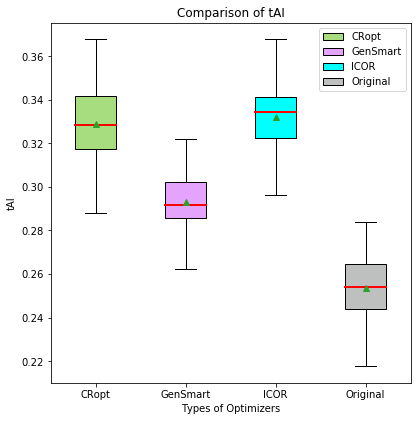

In [28]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
data = []
eva = "tAI"
with os.scandir(r"../results/csv") as files:
    sorted_files = sorted(files, key=lambda f: f.name)
for file in sorted_files:
    result = []
    df = pd.read_csv(file.path)
    print(file.name)
    for row in df[eva]:
        if type(row) == str:
            row= row.replace("%", "")
        #for nre, nce change float to int
        result.append(float(row))
    data.append(result)

fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data,patch_artist=True,showmeans=True )
colors = ['#a7dd7f','#e4a4fe','#01fffe','#bebfbf']
optimizers = ['CRopt','GenSmart','ICOR','Original']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
#for negative repeat elements change color to colr variable else red
for median,color in zip(bp['medians'], colors):
    median.set(color ="red",linewidth = 2)

ax.set_xticklabels(optimizers)
ax.set_title(f'Comparison of {eva}')
ax.set_ylabel(eva)
#for GC content and CFD remove the hastag in the below line
#ax.set_yticklabels(['{:,.0%}'.format(y/100) for y in ax.get_yticks()])
ax.set_xlabel('Types of Optimizers')
legend = [bp["boxes"][0],bp["boxes"][1],bp["boxes"][2],bp["boxes"][3]]
ax.legend(legend, optimizers)
# show plot
plt.show()

Mann whitney test

In [33]:
from scipy.stats import mannwhitneyu
df1 = pd.read_csv(r"../results/csv/original.csv")
df2 = pd.read_csv(r"../results/csv/CRopt.csv")
# define two groups of data
group1 = df1["tAI"]
group2 = df2["tAI"]

# perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

# print the results
print("Mann-Whitney U statistic: ", statistic)
print("p-value: ", p_value)

0.253452794225
0.015329670227964621
Mann-Whitney U statistic:  1600.0
p-value:  1.435085306393668e-14


In [7]:
!pip list

Package                   Version
------------------------- ---------
absl-py                   1.3.0
aiohttp                   3.8.1
aiosignal                 1.2.0
altgraph                  0.17.3
appdirs                   1.4.4
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
ase                       3.22.1
asttokens                 2.0.5
astunparse                1.6.3
async-timeout             4.0.1
attrs                     21.4.0
auto-py-to-exe            2.31.0
backcall                  0.2.0
beautifulsoup4            4.12.2
bel-resources             0.0.3
biopython                 1.80
bioregistry               0.5.59
bleach                    4.1.0
blinker                   1.4
blis                      0.7.8
bokeh                     2.4.3
bottle                    0.12.24
bottle-websocket          0.2.9
Bottleneck                1.3.4
brotlipy                  0.7.0
cachetools                4.2.2
cai2                      1.0.5
catalogue                 2


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
